In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import tikzplotlib as tpl

In [2]:
Tr = truthnet()
features, samples = Tr.load_data(datapath="data/PTSD_cognet_test_processed.csv")
Tr.fit(modelpath="tmp_Qnet.joblib")

In [3]:
Tr_pos = truthnet()
# feat_pos, samp_pos = pos_samps.columns, pos_samps.to_numpy(dtype='<U21', na_value='')
feat_pos, samp_pos = Tr_pos.load_data(
    datapath="data/PTSD_cognet_test_processed_pos_only.csv"
)
Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")

We order questions based on increasing entropy: questions with the least entropy have the most potential for dissonant/surprising responses. (This could also be done dynamically: after each response, recompute the distributions and choose the remaining one with minimal entropy.)

In [2]:
from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict


def _diss_linear(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            else:
                diss.append(np.inf)

    return np.array(diss)


def _compare_dissonance(
    samples, qnet, qnet_pos, order=None, diss_fcn=_diss_linear, plot=True
):
    samples_df = pd.DataFrame(samples)
    sample_values = pd.Series({col: samples_df[col].unique() for col in samples_df})

    if order is None:
        order = range(len(samples[0]))

    mean_diss_random = list()
    mean_diss_qsampled = list()
    mean_diss_m2 = list()
    mean_diss_m3 = list()

    new_samp_r = np.full_like(samples[0], fill_value="")
    new_samp_q = np.full_like(samples[0], fill_value="")
    new_samp_m2 = np.full_like(samples[0], fill_value="")
    new_samp_m3 = np.full_like(samples[0], fill_value="")

    for i in order:
        # generate answers randomly
        new_samp_r[i] = random.choice(sample_values[i])
        mean_diss_random.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_r, qnet)))
        )

        # baseline/comparison answers (generated from full model)
        prob_dict = qnet.predict_distribution(new_samp_q, i)
        new_samp_q[i] = sample_from_dict(prob_dict)
        mean_diss_qsampled.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_q, qnet)))
        )

        # generate answers from positive qnet distributions
        prob_dict_pos = qnet_pos.predict_distribution(new_samp_m2, i)
        new_samp_m2[i] = sample_from_dict(prob_dict_pos)
        mean_diss_m2.append(np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m2, qnet))))

        new_samp_m3[i] = random.choices(
            sample_values[i], weights=sample_values[i].astype(int) ** 2
        )[0]
        mean_diss_m3.append(np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m3, qnet))))

    mean_diss_qsampled = np.array(mean_diss_qsampled)
    mean_diss_random = np.array(mean_diss_random)
    mean_diss_m2 = np.array(mean_diss_m2)
    mean_diss_m3 = np.array(mean_diss_m3)

    mean_df = pd.DataFrame(
        {
            "random_diss": mean_diss_random,
            "qsampled_diss": mean_diss_qsampled,
            "m2_diss": mean_diss_m2,
            "m3_diss": mean_diss_m3,
        }
    )

    if plot is True:
        sns.relplot(
            data=pd.melt(
                mean_df.reset_index(),
                id_vars="index",
            ),
            x="index",
            y="value",
            hue="variable",
        )

    return pd.concat(
        [
            mean_df,
            pd.DataFrame(
                {
                    "random_resp": new_samp_r,
                    "qsampled_resp": new_samp_q,
                    "m2_resp": new_samp_m2,
                    "m3_resp": new_samp_m3,
                }
            ),
        ],
        axis=1,
    )

In [5]:
Ds = Tr.cognet_obj.qnet.predict_distributions(np.full_like(samples[0], fill_value=""))
entrpy = list()
for i in range(len(Ds)):
    entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))

entropy_order = pd.Series(entrpy).sort_values().index

## Linear dissonance

### Entropy ordering

In [6]:
mean_dfs = [
    _compare_dissonance(
        samples,
        Tr.cognet_obj.qnet,
        Tr_pos.cognet_obj.qnet,
        order=entropy_order,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

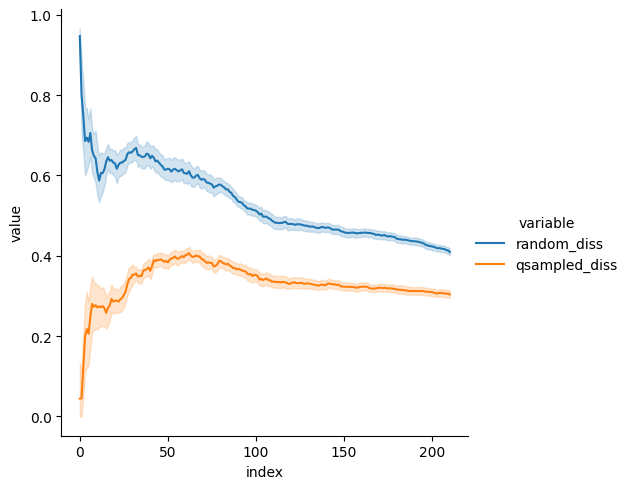

In [7]:
sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[["random_diss", "qsampled_diss"]].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

### Random ordering

In [8]:
random_order = list(range(len(samples[0])))
random.shuffle(random_order)

mean_dfs = [
    _compare_dissonance(
        samples,
        Tr.cognet_obj.qnet,
        Tr_pos.cognet_obj.qnet,
        order=random_order,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

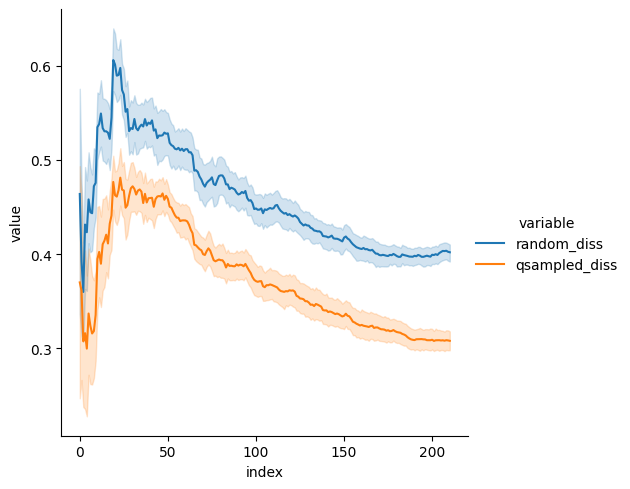

In [9]:
sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[["random_diss", "qsampled_diss"]].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

## Log. dissonance

In [10]:
mean_dfs = [
    _compare_dissonance(
        samples,
        Tr.cognet_obj.qnet,
        Tr_pos.cognet_obj.qnet,
        order=entropy_order,
        diss_fcn=_diss_log,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

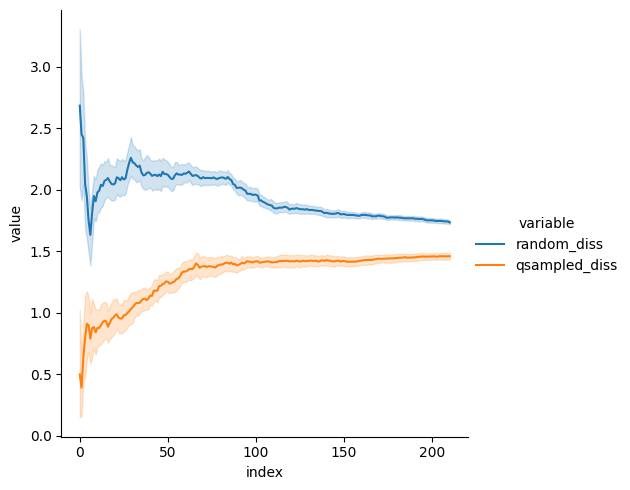

In [11]:
sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[["random_diss", "qsampled_diss"]].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

## Adversarial responses

In [12]:
mean_dfs = [
    _compare_dissonance(
        samples,
        Tr.cognet_obj.qnet,
        Tr_pos.cognet_obj.qnet,
        diss_fcn=_diss_log,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

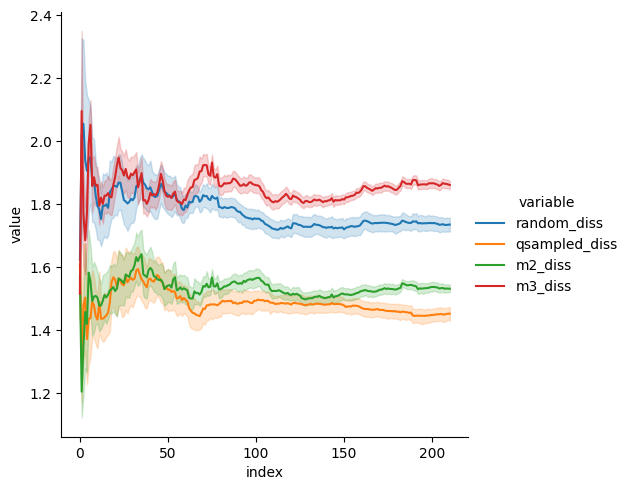

In [13]:
g = sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[
            ["random_diss", "qsampled_diss", "m2_diss", "m3_diss"]
        ].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

In [14]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

In [15]:
tikzplotlib_fix_ncols(g.figure)

In [16]:
print(
    tpl.get_tikz_code(
        g.figure,
        standalone=False,
    )
)

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{crimson2143940}{RGB}{214,39,40}
\definecolor{darkgray176}{RGB}{176,176,176}
\definecolor{darkorange25512714}{RGB}{255,127,14}
\definecolor{forestgreen4416044}{RGB}{44,160,44}
\definecolor{steelblue31119180}{RGB}{31,119,180}

\begin{axis}[
tick align=outside,
tick pos=left,
x grid style={darkgray176},
xlabel={index},
xmin=-10.5, xmax=220.5,
xtick style={color=black},
y grid style={darkgray176},
ylabel={value},
ymin=1.06216119160962, ymax=2.41216964553957,
ytick style={color=black}
]
\path [draw=steelblue31119180, fill=steelblue31119180, opacity=0.2]
(axis cs:0,1.69457518568338)
--(axis cs:0,1.54261523577751)
--(axis cs:1,1.70772735425227)
--(axis cs:2,1.77665606746733)
--(axis cs:3,1.70933634920906)
--(axis cs:4,1.69157086834151)
--(axis cs:5,1.77184908581238)
--(axis cs:6,1.80443200593842)
--(axis cs:7,1.74409150134051)
--(axis cs:8,1.74265054301535)
--(axis cs:9,1.72056418470889)
--(axis cs:10,1.687344

## Classification


Get dissonance values for specified number of runs, process for classifier training

In [17]:
df_tra = pd.concat(
    [
        _compare_dissonance(
            samples,
            Tr.cognet_obj.qnet,
            Tr_pos.cognet_obj.qnet,
            order=entropy_order,
            plot=False,
        ).assign(run=i)
        for i in tqdm(range(20))
    ]
)

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
df_tst = pd.concat(
    [
        _compare_dissonance(
            samples,
            Tr.cognet_obj.qnet,
            Tr_pos.cognet_obj.qnet,
            order=entropy_order,
            plot=False,
        ).assign(run=i)
        for i in range(5)
    ]
)

In [3]:
def _get_quest_diss(diss_df, questions):
    qs_df = pd.DataFrame(
        [
            diss_df.groupby("run").nth(i)["qsampled_diss"].values
            for i in range(questions)
        ]
    ).T.assign(group="qsampled")
    m2_df = pd.DataFrame(
        [diss_df.groupby("run").nth(i)["m2_diss"].values for i in range(questions)]
    ).T.assign(group="m2")

    return pd.concat([qs_df, m2_df])

In [4]:
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
)

In [21]:
fig, ax = plt.subplots()

aucs = list()

quest_iter = range(1, 211, 5)

for i in quest_iter:
    tra = _get_quest_diss(df_tra, i)
    X_train = tra.iloc[:, :i]
    y_train = tra.iloc[:, -1]

    tst = _get_quest_diss(df_tst, i)
    X_test = tst.iloc[:, :i]
    y_test = tst.iloc[:, -1]
    forest = RandomForestClassifier(n_estimators=100, oob_score=True)
    forest.fit(X_train, y_train)

    r = RocCurveDisplay.from_estimator(
        forest, X_test, y_test, pos_label="m2", ax=ax, name=tra.columns[i - 1]
    )
    aucs.append(r.roc_auc)
    plt.close()

# ax.legend(bbox_to_anchor=(1.1, 1.05))

<Axes: xlabel='questions asked'>

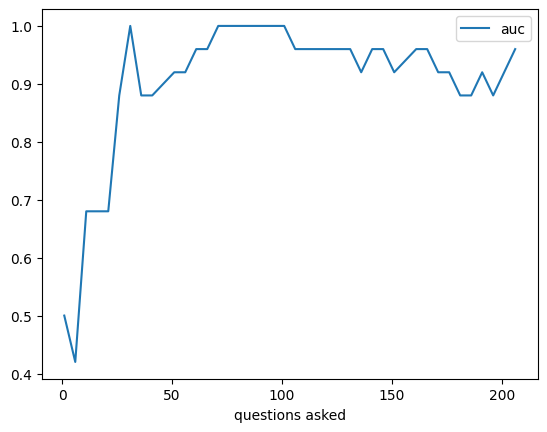

In [22]:
auc_df = pd.DataFrame({"questions asked": quest_iter, "auc": aucs})

auc_df.plot(x="questions asked", y="auc")

In [24]:
auc_df.to_csv("data/classification/auc_df.csv", index=False)

## batch run

In [5]:
def _get_auc_df(n_train=20, n_test=5):
    Tr = truthnet()
    features, samples = Tr.load_data(datapath="data/PTSD_cognet_test_processed.csv")
    Tr.fit(modelpath="tmp_Qnet.joblib")
    Tr_pos = truthnet()
    # feat_pos, samp_pos = pos_samps.columns, pos_samps.to_numpy(dtype='<U21', na_value='')
    feat_pos, samp_pos = Tr_pos.load_data(
        datapath="data/PTSD_cognet_test_processed_pos_only.csv"
    )
    Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")

    Ds = Tr.cognet_obj.qnet.predict_distributions(
        np.full_like(samples[0], fill_value="")
    )
    entrpy = list()
    for i in range(len(Ds)):
        entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))

    entropy_order = pd.Series(entrpy).sort_values().index

    fig, ax = plt.subplots()

    df_tra = pd.concat(
        [
            _compare_dissonance(
                samples,
                Tr.cognet_obj.qnet,
                Tr_pos.cognet_obj.qnet,
                order=entropy_order,
                plot=False,
            ).assign(run=i)
            for i in tqdm(range(n_train))
        ]
    )

    df_tst = pd.concat(
        [
            _compare_dissonance(
                samples,
                Tr.cognet_obj.qnet,
                Tr_pos.cognet_obj.qnet,
                order=entropy_order,
                plot=False,
            ).assign(run=i)
            for i in tqdm(range(n_test))
        ]
    )

    aucs = list()

    quest_iter = range(1, 211, 5)

    for i in quest_iter:
        tra = _get_quest_diss(df_tra, i)
        X_train = tra.iloc[:, :i]
        y_train = tra.iloc[:, -1]

        tst = _get_quest_diss(df_tst, i)
        X_test = tst.iloc[:, :i]
        y_test = tst.iloc[:, -1]
        forest = RandomForestClassifier(n_estimators=100, oob_score=True)
        forest.fit(X_train, y_train)

        r = RocCurveDisplay.from_estimator(
            forest, X_test, y_test, pos_label="m2", ax=ax, name=tra.columns[i - 1]
        )
        aucs.append(r.roc_auc)
        plt.close()

    auc_df = pd.DataFrame({"questions asked": quest_iter, "auc": aucs})
    return auc_df

In [ ]:
for i in tqdm(range(10)):
    _get_auc_df().to_csv("auc_df_" + str(i) + ".csv", index=False)

In [8]:
pd.concat([pd.read_csv("auc_df_" + str(i) + ".csv") for i in range(10)]).to_csv(
    "auc_df_x10.csv", index=False
)

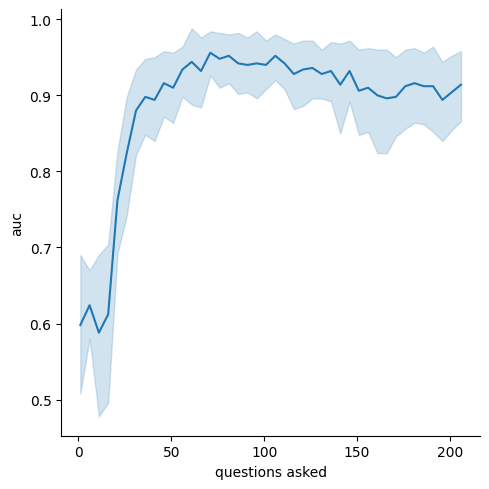

In [14]:
g = sns.relplot(
    data=pd.read_csv("auc_df_x10.csv"), x="questions asked", y="auc", kind="line"
)

In [16]:
print(tpl.get_tikz_code(g.figure, standalone=False))

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{darkgray176}{RGB}{176,176,176}
\definecolor{steelblue31119180}{RGB}{31,119,180}

\begin{axis}[
tick align=outside,
tick pos=left,
x grid style={darkgray176},
xlabel={questions asked},
xmin=-9.25, xmax=216.25,
xtick style={color=black},
y grid style={darkgray176},
ylabel={auc},
ymin=0.4525, ymax=1.0135,
ytick style={color=black}
]
\path [draw=steelblue31119180, fill=steelblue31119180, opacity=0.2]
(axis cs:1,0.69005)
--(axis cs:1,0.50795)
--(axis cs:6,0.58)
--(axis cs:11,0.478)
--(axis cs:16,0.496)
--(axis cs:21,0.69195)
--(axis cs:26,0.742)
--(axis cs:31,0.822)
--(axis cs:36,0.84795)
--(axis cs:41,0.84)
--(axis cs:46,0.872)
--(axis cs:51,0.86395)
--(axis cs:56,0.898)
--(axis cs:61,0.8879)
--(axis cs:66,0.884)
--(axis cs:71,0.926)
--(axis cs:76,0.91)
--(axis cs:81,0.916)
--(axis cs:86,0.902)
--(axis cs:91,0.904)
--(axis cs:96,0.896)
--(axis cs:101,0.908)
--(axis cs:106,0.92)
--(axis cs:111,0.908)
--(axis

## Def. of dissonance

Letting $\text{ans}$ be the set of answers and a response $x \in \text{ans}$, the (linear) dissonance of $x$ is defined as $$\operatorname{Dissonance}(x)= 1 - \dfrac{\operatorname{Pr}(x)}{\operatorname{max}_{a \in \text{ans}}\operatorname{Pr}(a)}$$ 

Thus the dissonance is supported on $[0,1]$, is minimized at the highest probability response, and is maximal ($=1$) at probability $0$ responses. We also see that it scales linearly with probability of the response.

## Results

- distinguish between random/non-random responses
- reconstruction of responses
- include diagnostic phenotypes